# Assignment 6

In [1]:
import torch
print("Using torch", torch.__version__)

Using torch 2.2.1+cu121


In [2]:
## Standard libraries
import os
import math
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import cv2
## Progress bar
from tqdm.notebook import tqdm

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)


Device cuda


In [4]:
import torch.nn as nn

In [5]:
import torchvision
import torchvision.transforms as transforms

In [6]:
from torch.utils.data import DataLoader

In [7]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [8]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 16059640.50it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 484192.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4385804.25it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20309732.16it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
train_dataset

## Task1

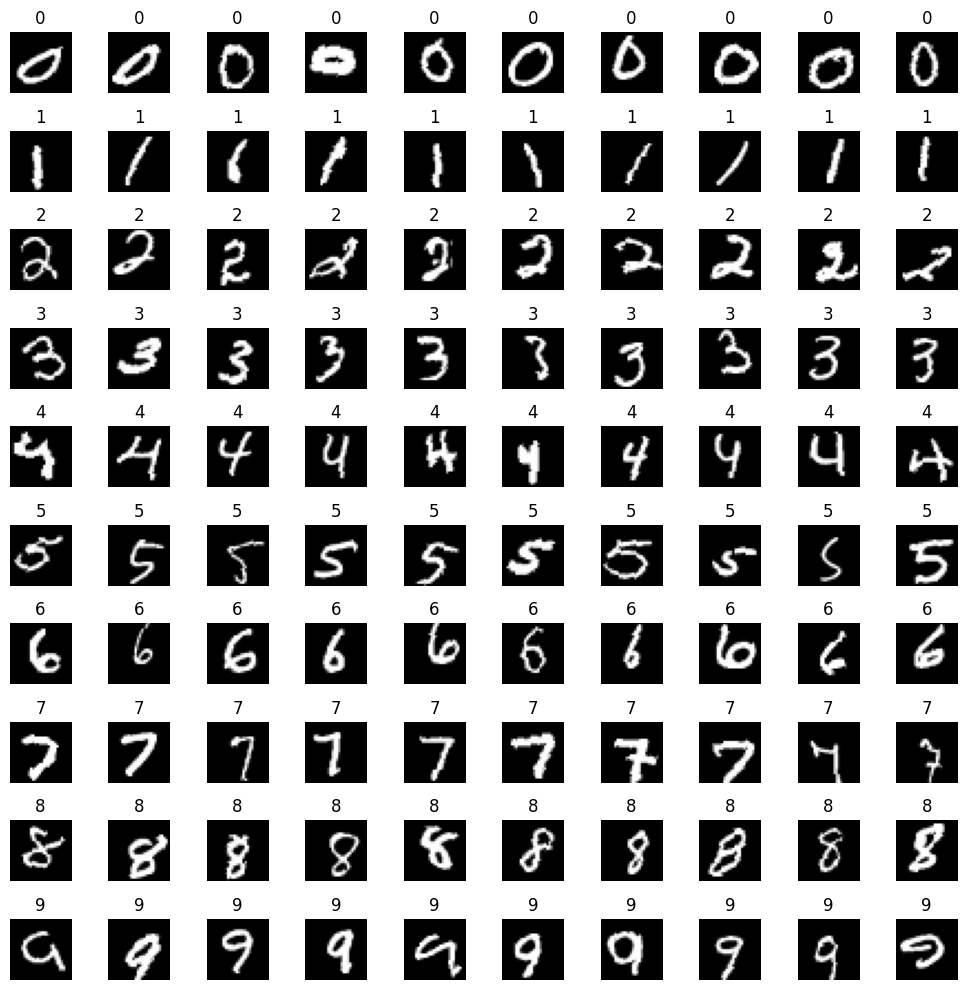

In [12]:
def plot_images(dataset, class_names):
    fig, axes = plt.subplots(nrows=len(class_names), ncols=10, figsize=(10, 10))
    for i, class_name in enumerate(class_names):
        class_samples = [img for img, label in dataset if label == i]
        for j in range(10):
            axes[i, j].imshow(class_samples[j][0], cmap='gray')
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Plot images from each class
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_images(train_dataset, class_names)

## Task2

In [13]:
import torch.nn.functional as F

class MLP1(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP1, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.Linear(hidden_size1, hidden_size2),
            nn.Linear(hidden_size2, output_size)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten input if it's not already
        x = self.model(x)
        return x

class MLP2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, output_size)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten input if it's not already
        x = self.model(x)
        return x


In [15]:
model1 = MLP1(input_size = 784, hidden_size1= 1024, hidden_size2= 512, output_size = 10)

In [16]:
model2 = MLP2(input_size = 784, hidden_size1= 1024, hidden_size2= 512, output_size = 10)

## Task3

In [17]:
import torch
import numpy as np
def train_model(model, loss_fn, optimizer, train_loader, val_loader=None, num_epochs=5, device=device):
    train_acc_list=[]
    val_acc_list=[]
    train_loss_list=[]
    val_loss_list=[]
    model.to(device)
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_corrects = 0
        total_samples = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)

        train_loss /= total_samples
        train_acc = train_corrects / total_samples
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        if val_loader:
            val_loss, val_acc = evaluate_model(model, loss_fn, val_loader, device)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        else:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    print("Training is completed!")
    return train_acc_list, val_acc_list, train_loss_list, val_loss_list

def evaluate_model(model, loss_fn, dataloader, device='cuda'):
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)

    val_loss /= total_samples
    val_acc = val_corrects / total_samples
    return val_loss, val_acc


In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)

In [19]:
train_acc_list1 = []
val_acc_list1 = []
train_loss_list1 = []
val_loss_list1 = []
train_acc_list1, val_acc_list1, train_loss_list1, val_loss_list1 = train_model(model1, loss_fn, optimizer1, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Train Loss: 8.4526, Train Acc: 0.6185, Val Loss: 1.0663, Val Acc: 0.6726
Epoch 2/5, Train Loss: 1.0461, Train Acc: 0.6723, Val Loss: 1.0868, Val Acc: 0.6629
Epoch 3/5, Train Loss: 1.0587, Train Acc: 0.6689, Val Loss: 1.0498, Val Acc: 0.6822
Epoch 4/5, Train Loss: 1.1520, Train Acc: 0.6446, Val Loss: 1.3110, Val Acc: 0.6030
Epoch 5/5, Train Loss: 423.1715, Train Acc: 0.5663, Val Loss: 14.0696, Val Acc: 0.6292
Training is completed!


In [20]:
train_acc_list2 = []
val_acc_list2 = []
train_loss_list2 = []
val_loss_list2 = []
train_acc_list2, val_acc_list2, train_loss_list2, val_loss_list2 = train_model(model2, loss_fn, optimizer2, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Train Loss: 0.9396, Train Acc: 0.7220, Val Loss: 0.6489, Val Acc: 0.7925
Epoch 2/5, Train Loss: 0.6156, Train Acc: 0.8095, Val Loss: 0.5498, Val Acc: 0.8289
Epoch 3/5, Train Loss: 0.5650, Train Acc: 0.8294, Val Loss: 0.6697, Val Acc: 0.8026
Epoch 4/5, Train Loss: 0.5476, Train Acc: 0.8353, Val Loss: 0.5758, Val Acc: 0.8208
Epoch 5/5, Train Loss: 0.5216, Train Acc: 0.8423, Val Loss: 0.5366, Val Acc: 0.8343
Training is completed!


## Task4

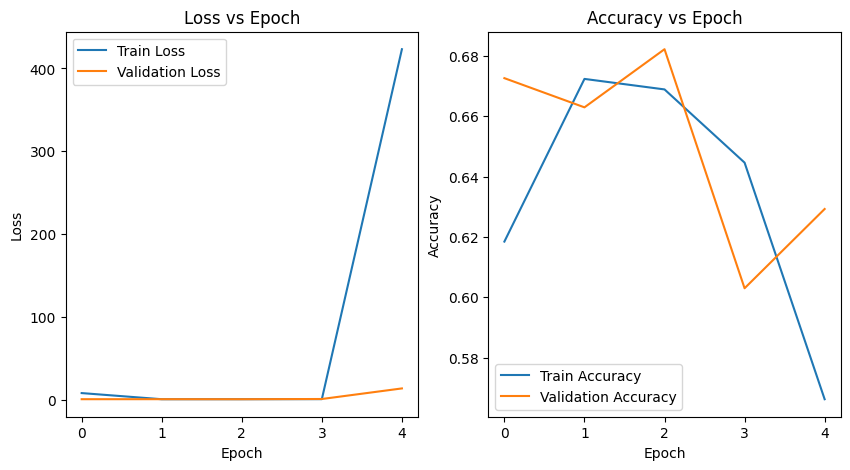

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list1, label='Train Loss')
plt.plot(val_loss_list1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list1, label='Train Accuracy')
plt.plot(val_acc_list1, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()



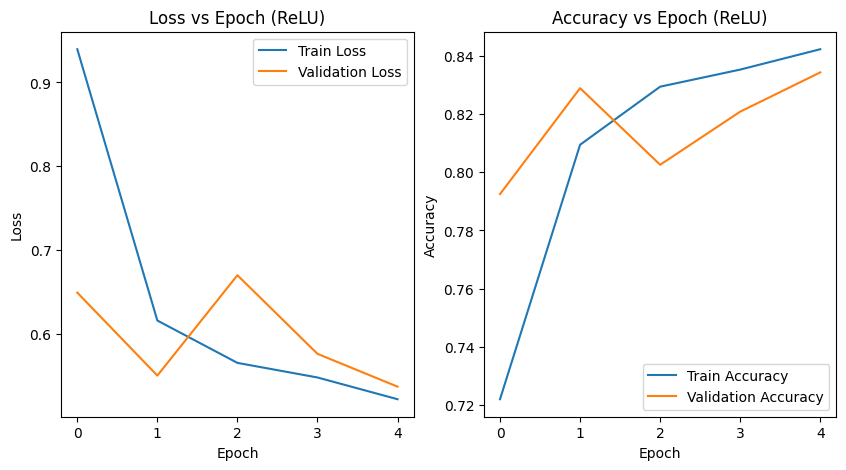

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list2, label='Train Loss')
plt.plot(val_loss_list2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch (ReLU)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list2, label='Train Accuracy')
plt.plot(val_acc_list2, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch (ReLU)')
plt.legend()

plt.show()



In [23]:
model1.eval()
correct_pred=[]
incorrect_pred=[]
with torch.no_grad():
  for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    logit = model1(X)
    preds = torch.argmax(logit,1)
    for i in range(len(y)):
        if preds[i] == y[i]:
            correct_pred.append((X[i].cpu(), preds[i].cpu().item()))
        else:
            incorrect_pred.append((X[i].cpu(), preds[i].cpu().item()))


Correct Predictions:


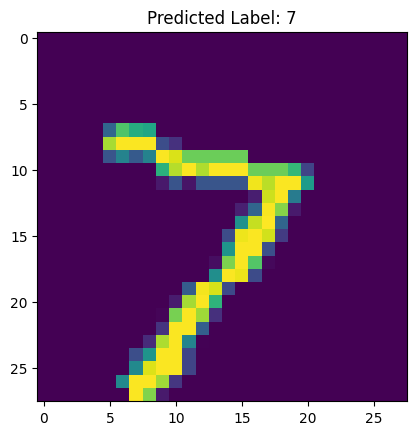

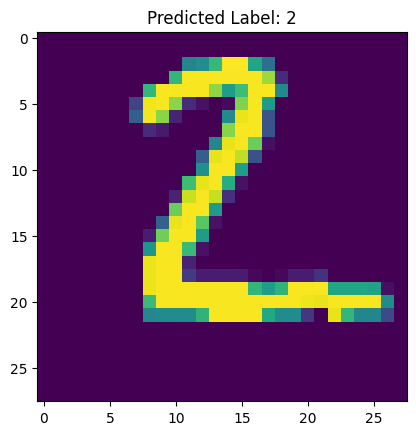

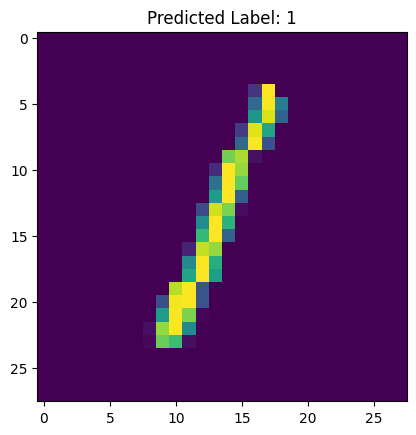

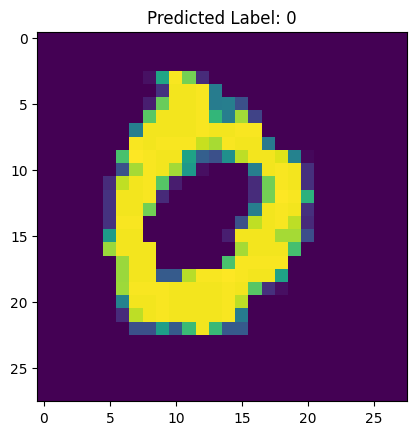

Incorrect Predictions:


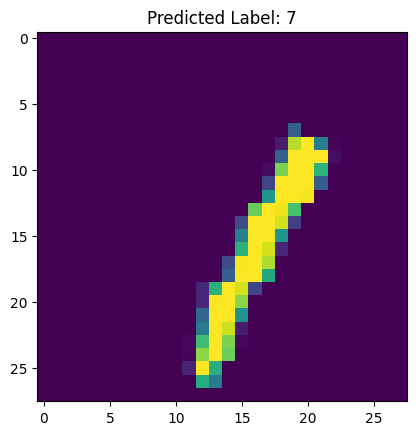

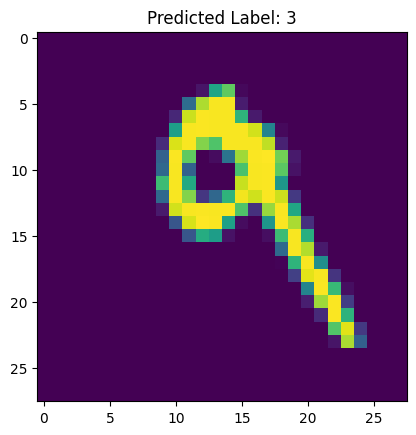

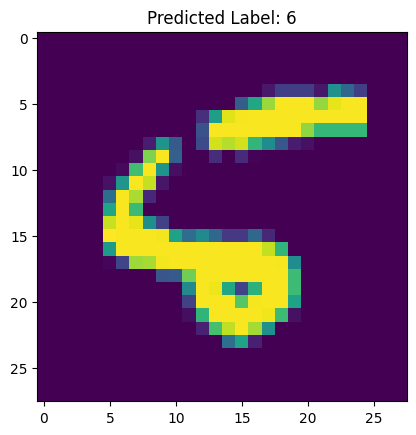

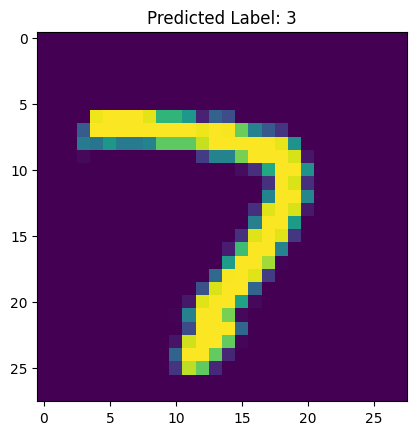

In [24]:

    # Visualize correct predictions
print("Correct Predictions (without ReLU):")
for img, label in correct_pred[:4]:
  plt.imshow(torch.squeeze(img))
  plt.title(f"Predicted Label: {label}")
  plt.show()

# Visualize incorrect predictions
print("Incorrect Predictions (without ReLU):")
for img, label in incorrect_pred[:4]:
  plt.imshow(torch.squeeze(img))
  plt.title(f"Predicted Label: {label}")
  plt.show()

In [25]:
model2.eval()
correct_pred=[]
incorrect_pred=[]
with torch.no_grad():
  for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    logit = model2(X)
    preds = torch.argmax(logit,1)
    for i in range(len(y)):
        if preds[i] == y[i]:
            correct_pred.append((X[i].cpu(), preds[i].cpu().item()))
        else:
            incorrect_pred.append((X[i].cpu(), preds[i].cpu().item()))


Correct Predictions:


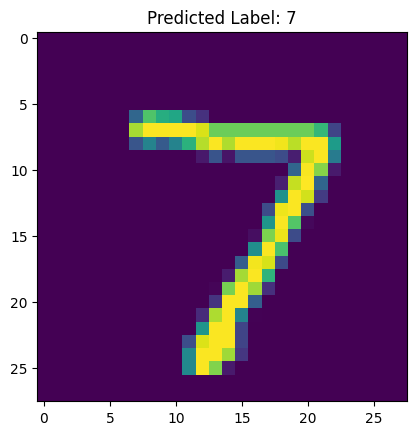

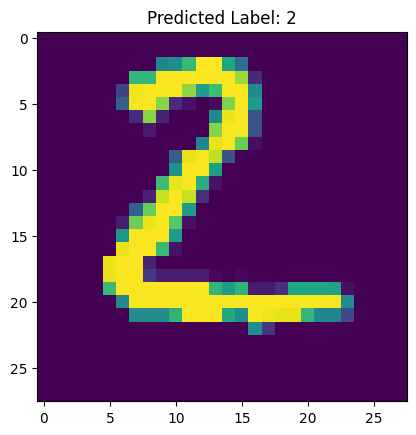

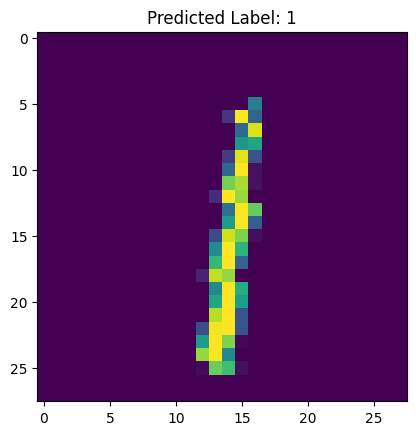

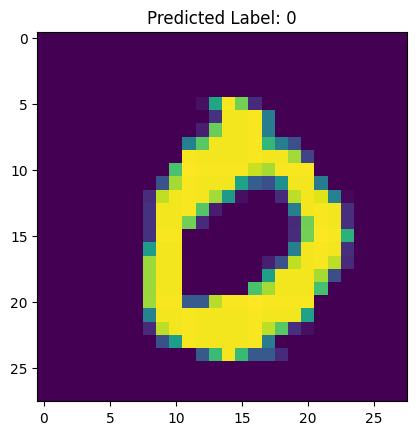

Incorrect Predictions:


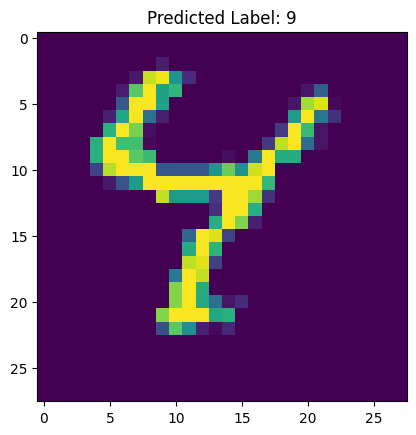

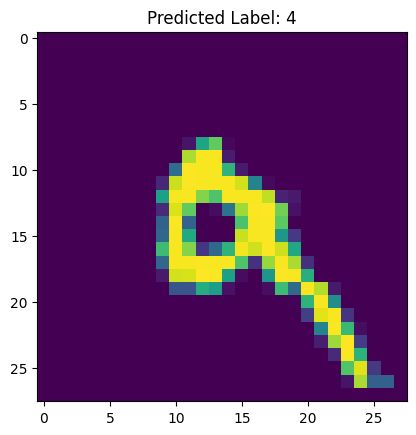

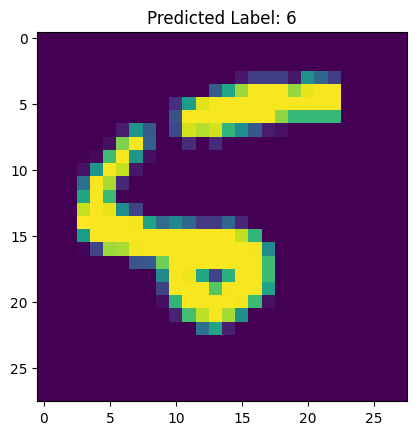

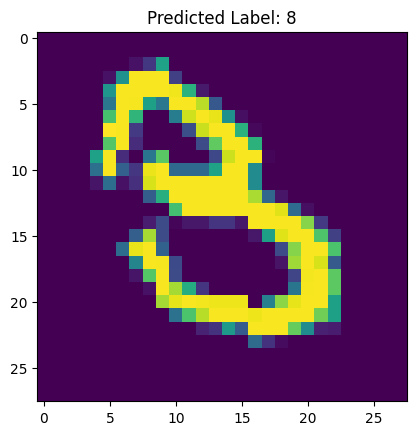

In [26]:

    # Visualize correct predictions
print("Correct Predictions (ReLU):")
for img, label in correct_pred[:4]:
  plt.imshow(torch.squeeze(img))
  plt.title(f"Predicted Label: {label}")
  plt.show()

# Visualize incorrect predictions
print("Incorrect Predictions:")
for img, label in incorrect_pred[:4]:
  plt.imshow(torch.squeeze(img))
  plt.title(f"Predicted Label: {label}")
  plt.show()